## Numerical Resolution of Stochastic Differential Equations

### 1. We discretize the Black & Scholes SDE with an Euler scheme and a Milstein scheme, illustrating the convergence.

Black & Scholes SDE (risk-neutral probability): $$dS_t = r S_t dt + \sigma S_t dW_t$$

**Euler-Maruyama Scheme:**

$$S_{t_{i+1}} = S_{t_i} + a(S_i) \Delta t + b(S_i) \Delta W_i $$

$$S_{t_{i+1}} = S_{t_i} + r S_{t_i} \Delta t + \sigma S_{t_i} \sqrt{\Delta t}Z_i $$

With Zi being independent standard normal Gaussian variables.

The Euler scheme is of strong order 1/2 and weak order 1.

**Milstein Scheme:**
$$S_{t_{i+1}} = S_{t_i} + a(S_i)\Delta t + b(S_i)\Delta W_t + \frac{1}{2}b(S_i)b'(S_i) ((\Delta W_t)^2 - \Delta t)$$

$$S_{t_{i+1}} = S_{t_i} + r S_{t_i} \Delta t + \sigma S_{t_i} \Delta t Z_i + \frac{1}{2} \sigma^2 S_{t_i} \Delta t(Z_i^2 - 1)$$

(The Milstein scheme adds a second-order corrective term).

The Milstein scheme is of strong order 1 and weak order 1.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Model Parameters ---
S0 = 100
K = 100.0
r = 0.05
sigma = 0.20
T = 1.0
M = 1000  # Number of trajectories to calculate the average error (Monte Carlo)

# Function for the exact solution (Black-Scholes)
def bs_exact_solution(S0, T, r, sigma, W_T):
    return S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * W_T)

In [19]:
def simulate_schemes(S0, T, r, sigma, N_steps):
    """
    Simulates a single trajectory with Euler and Milstein sharing the same Brownian increments.
    Returns the final point S_T for Euler, Milstein, and Exact.
    """
    dt = T / N_steps
    sqrt_dt = np.sqrt(dt)

    # Generation of Brownian increments for the entire trajectory
    dW = np.random.randn(N_steps) * sqrt_dt

    # Initialization
    S_euler = S0
    S_milstein = S0

    for i in range(N_steps):
        dw_i = dW[i]

        # 1. Euler
        S_euler = S_euler + r * S_euler * dt + sigma * S_euler * dw_i

        # 2. Milstein
        milstein_correction = 0.5 * sigma**2 * S_milstein * (dw_i**2 - dt)
        S_milstein = S_milstein + r * S_milstein * dt + sigma * S_milstein * dw_i + milstein_correction

    # 3. Exact Solution
    W_T = np.sum(dW)
    S_exact = bs_exact_solution(S0, T, r, sigma, W_T)

    return S_euler, S_milstein, S_exact

**Convergence Analysis:** p corresponds to the convergence order

Strong Convergence: $$E[|S_T^{approx} - S_T^{exact}|] \le C \cdot (\Delta t)^p$$

Weak Convergence: $$|E[f(S_T^{approx})] - E[f(S_T^{exact})]| \le C \cdot (\Delta t)^q$$

In [20]:
# List of discretization steps (N increases => dt decreases)
N_values = [10, 20, 50, 100, 200, 500]
dt_values = [T/n for n in N_values]

euler_errors = []
milstein_errors = []

print("Calculating convergence errors...")

for N in N_values:
    err_euler_sum = 0
    err_milstein_sum = 0

    # We average over M trajectories to get a robust expectation
    for _ in range(M):
        S_e, S_m, S_ex = simulate_schemes(S0, T, r, sigma, N)

        # Strong absolute error
        err_euler_sum += np.abs(S_e - S_ex)
        err_milstein_sum += np.abs(S_m - S_ex)

    euler_errors.append(err_euler_sum / M)
    milstein_errors.append(err_milstein_sum / M) # Moved inside the loop

Calculating convergence errors...


<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-4256040604.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("Time Step $\Delta t$ (log scale)")


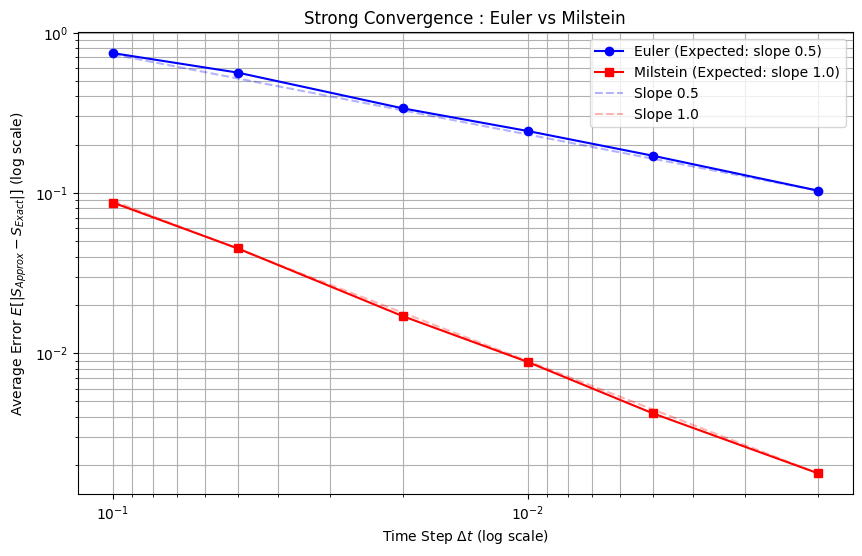

Estimated Euler slope : 0.51 (Theory : 0.5)
Estimated Milstein slope : 1.00 (Theory : 1.0)


In [21]:
# Log-Log Plot
plt.figure(figsize=(10, 6))

plt.loglog(dt_values, euler_errors, 'b-o', label='Euler (Expected: slope 0.5)')
plt.loglog(dt_values, milstein_errors, 'r-s', label='Milstein (Expected: slope 1.0)')
plt.loglog(dt_values, [euler_errors[-1] * (dt/dt_values[-1])**0.5 for dt in dt_values], 'b--', alpha=0.3, label='Slope 0.5')
plt.loglog(dt_values, [milstein_errors[-1] * (dt/dt_values[-1])**1.0 for dt in dt_values], 'r--', alpha=0.3, label='Slope 1.0')

plt.title("Strong Convergence : Euler vs Milstein")
plt.xlabel("Time Step $\Delta t$ (log scale)")
plt.ylabel("Average Error $E[|S_{Approx} - S_{Exact}|]$ (log scale)")
plt.legend()
plt.grid(True, which="both", ls="-")
plt.gca().invert_xaxis() # Invert the X axis to see dt decrease to the right (convergence)
plt.show()

# Slope Calculation
slope_euler = np.polyfit(np.log(dt_values), np.log(euler_errors), 1)[0]
slope_milstein = np.polyfit(np.log(dt_values), np.log(milstein_errors), 1)[0]

print(f"Estimated Euler slope : {slope_euler:.2f} (Theory : 0.5)")
print(f"Estimated Milstein slope : {slope_milstein:.2f} (Theory : 1.0)")

When the number of simulated slopes is large, the numerical solutions overlap with the theoretical convergence slopes. We clearly observe that the Milstein scheme converges much faster than the Euler scheme for constant t and M.

### 2. We implement the pricing of a standard call in the Heston model via Monte Carlo, with the simple Euler scheme proposed.

**Heston Model:**
$$dS_t = r S_t dt + \sqrt{v_t} S_t dB_t^1$$
$$dv_t = -\lambda (v_t - \bar{v}) dt + \eta \sqrt{v_t} dB_t^2$$
$$d\langle B^1, B^2 \rangle_t = \rho dt$$


**Algo:**

**A.** Corrélation des Bruits : Noise Correlation: We generate two independent Gaussians $Z_1, Z_2 \sim \mathcal{N}(0,1)$. We construct the correlated Brownian motions as follows: $$\Delta B_1 = \sqrt{\Delta t} \cdot Z_1$$
$$\Delta B_2 = \sqrt{\Delta t} \cdot (\rho Z_1 + \sqrt{1 - \rho^2} Z_2)$$


**B.** Variance Update  ($v_{t+1}$) (Euler scheme):$$v_{t+1} = v_t - \lambda(v_t - \bar{v})\Delta t + \eta \sqrt{v_t} \Delta B_2$$


**C.** Price Update  ($S_{t+1}$) (Euler scheme):$$S_{t+1} = S_t + r S_t \Delta t + \sqrt{v_t} S_t \Delta B_1$$

In [22]:
# Heston Parameters
v0 = 0.04        # Initial variance
v_bar = 0.04     # Long-term variance
lambd = 2.0      # Mean reversion speed
eta = 0.3        # Volatility of volatility
rho = -0.5       # Correlation (negative because a bear market often implies price agitation)

N_sim = 50000
N_steps = 100

def heston_monte_carlo_pricing(S0, K, T, r, v0, v_bar, lambd, eta, rho, N_sim, N_steps):
    """
    Pricing of a European Call under the Heston model via Monte Carlo.
    Euler scheme with 'Full Truncation' for variance.
    """
    dt = T / N_steps
    sqrt_dt = np.sqrt(dt)

    # Initialization of vectors (N_sim trajectories in parallel)
    S = np.full(N_sim, S0)
    v = np.full(N_sim, v0)

    for i in range(N_steps):
        # A.
        Z1 = np.random.randn(N_sim)
        Z2_uncorr = np.random.randn(N_sim)
        W1 = Z1
        W2 = rho * Z1 + np.sqrt(1 - rho**2) * Z2_uncorr

        # B
        v_plus = np.maximum(v, 0)
        v_sqrt = np.sqrt(v_plus)
        v_next = v - lambd * (v - v_bar) * dt + eta * v_sqrt * sqrt_dt * W2

        # C.
        S_next = S + r * S * dt + v_sqrt * S * sqrt_dt * W1

        # Advance one step
        v = v_next
        S = S_next

    # Payoff and Price Calculation
    payoffs = np.maximum(S - K, 0)

    # Discounting
    price = np.exp(-r * T) * np.mean(payoffs)

    # Standard error (for confidence interval)
    std_dev = np.std(payoffs)
    std_error = std_dev / np.sqrt(N_sim)

    return price, std_error

In [23]:
# --- Execution ---
price, error = heston_monte_carlo_pricing(S0, K, T, r, v0, v_bar, lambd, eta, rho, N_sim, N_steps)
ci_width = 1.96 * error

print(f"--- Heston Model (Monte Carlo Euler) ---")
print(f"Parameters : S0={S0}, K={K}, T={T}, r={r}")
print(f"Heston : v0={v0}, v_bar={v_bar}, lambda={lambd}, eta={eta}, rho={rho}")
print(f"\nEstimated Call Price : {price:.4f}")
print(f"95% Confidence Interval : [{price - ci_width:.4f}, {price + ci_width:.4f}]")

--- Heston Model (Monte Carlo Euler) ---
Parameters : S0=100, K=100.0, T=1.0, r=0.05
Heston : v0=0.04, v_bar=0.04, lambda=2.0, eta=0.3, rho=-0.5

Estimated Call Price : 10.4098
95% Confidence Interval : [10.2898, 10.5298]


### 3. We implement the calculation of the Black & Scholes implied volatility by bisection. We can reduce it to a bounded interval by writing $S_{t}=\frac{x}{1-x}$ , $x\in[0,1]$.

We want to "invert" the Black & Scholes formula to obtain the volatility allowing equality between the price of this call and the market price: $C_{B\&S}(\sigma(t)) - C_{market}(t) = 0$

However  $\sigma \in [0,+∞[$, we reduce it to $x \in [0, 1[$ by setting $\sigma = \frac{x}{1-x}$ and thus apply the bisection method.

**Algo:**

1. We perform a bisection on $x$. We start from $[x_{min}, x_{max}] = [0, 1]$.

2. We take the midpoint $x_{mid}$, we calculate the corresponding $\sigma_{mid}$.

3. We calculate the Black-Scholes price $P_{BS}(\sigma_{mid})$.

4. If $P_{BS} < P_{Cible}$,  then the volatility is too low ($x_{min} = x_{mid}$). Otherwise, it is too high ($x_{max} = x_{mid}$).

In [24]:
# --- Black-Scholes Base Functions ---

def bs_call_price(S0, K, T, r, sigma):
    """Black-Scholes closed-form formula for a European Call"""
    # Edge case: sigma very close to 0
    if sigma < 1e-9:
        return np.maximum(S0 - K * np.exp(-r * T), 0)

    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return price

def implied_volatility_solver(target_price, S0, K, T, r):
    """
    Finds the implied volatility by bisection on the interval [0, 1)
    via the transformation sigma = x / (1-x).
    """

    # Bisection on x in [0, 1]
    x_low = 0.0
    x_high = 1.0 - 1e-9 # Avoid exact division by zero

    # Precision and iterations
    epsilon = 1e-6
    max_iter = 100

    for i in range(max_iter):
        x_mid = (x_low + x_high) / 2

        # Inverse transformation
        sigma_mid = x_mid / (1 - x_mid)

        # BS price calculation with this sigma
        price_mid = bs_call_price(S0, K, T, r, sigma_mid)

        # Convergence test
        if abs(price_mid - target_price) < epsilon:
            return sigma_mid

        # Boundary adjustment (BS is increasing in sigma)
        if price_mid < target_price:
            x_low = x_mid   # Not enough vol, search higher
        else:
            x_high = x_mid  # Too much vol, search lower

    # If we exit the loop, return the best estimate
    x_final = (x_low + x_high) / 2
    return x_final / (1 - x_final)

In [25]:
# Unit Test
# Verify that if we calculate a price with sigma=30%, the inverter correctly finds 30%
S_test = 100; K_test = 100; T_test = 1.0; r_test = 0.05
true_sigma = 0.30

# Calculate theoretical price
price_ref = bs_call_price(S_test, K_test, T_test, r_test, true_sigma)
print(f"Target BS Price (sigma={true_sigma:.2f}) : {price_ref:.4f}")

# Inversion
implied_vol = implied_volatility_solver(price_ref, S_test, K_test, T_test, r_test)
print(f"Found Implied Volatility   : {implied_vol:.6f}")

# Verification
assert abs(implied_vol - true_sigma) < 1e-4, "Error in volatility inversion !!!"
print("Inversion works :)")

Target BS Price (sigma=0.30) : 14.2313
Found Implied Volatility   : 0.300000
Inversion works :)


### 4. We plot an example of a volatility smile in the Heston model.

1. We calculate the Heston call price using Part 2.
2. We invert the Black & Scholes formula to obtain the vol such that the two models return the same result using Part 3.

In [26]:
# Smile Construction

# Parameters
S0 = 100.0; T = 1.0; r = 0.03
v0 = 0.04; v_bar = 0.04; lambd = 2.0; eta = 0.3; rho = -0.5

# List of Strikes
strikes = np.linspace(80, 180, 30)
implied_vols = []

print("Calculating the smile...")

for K in strikes:
    # cf. Q2
    price_heston, _ = heston_monte_carlo_pricing(S0, K, T, r, v0, v_bar, lambd, eta, rho, 100000, 100)

    # cf. Q3
    iv = implied_volatility_solver(price_heston, S0, K, T, r)
    implied_vols.append(iv)
    print(f"Strike K={K:5.1f} -> Price={price_heston:6.3f} -> IV={iv:.2%}")

Calculating the smile...
Strike K= 80.0 -> Price=23.459 -> IV=21.42%
Strike K= 83.4 -> Price=20.657 -> IV=21.39%
Strike K= 86.9 -> Price=17.932 -> IV=20.99%
Strike K= 90.3 -> Price=15.474 -> IV=20.94%
Strike K= 93.8 -> Price=13.011 -> IV=20.27%
Strike K= 97.2 -> Price=10.878 -> IV=20.00%
Strike K=100.7 -> Price= 8.848 -> IV=19.43%
Strike K=104.1 -> Price= 7.136 -> IV=19.11%
Strike K=107.6 -> Price= 5.622 -> IV=18.73%
Strike K=111.0 -> Price= 4.416 -> IV=18.56%
Strike K=114.5 -> Price= 3.359 -> IV=18.24%
Strike K=117.9 -> Price= 2.514 -> IV=17.98%
Strike K=121.4 -> Price= 1.873 -> IV=17.82%
Strike K=124.8 -> Price= 1.365 -> IV=17.65%
Strike K=128.3 -> Price= 0.971 -> IV=17.44%
Strike K=131.7 -> Price= 0.713 -> IV=17.46%
Strike K=135.2 -> Price= 0.482 -> IV=17.21%
Strike K=138.6 -> Price= 0.342 -> IV=17.19%
Strike K=142.1 -> Price= 0.230 -> IV=17.05%
Strike K=145.5 -> Price= 0.152 -> IV=16.91%
Strike K=149.0 -> Price= 0.120 -> IV=17.23%
Strike K=152.4 -> Price= 0.078 -> IV=17.08%
Strike 

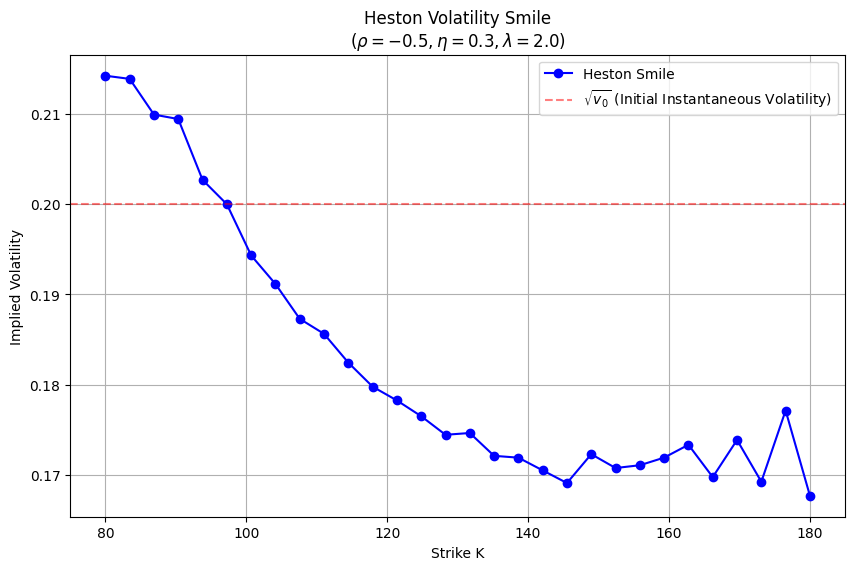

In [27]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(strikes, implied_vols, 'b-o', label='Heston Smile')
plt.axhline(np.sqrt(v0), color='r', linestyle='--', label='$\\sqrt{v_0}$ (Initial Instantaneous Volatility)', alpha=0.5)

plt.title(f"Heston Volatility Smile\n($\\rho={rho}, \\eta={eta}, \\lambda={lambd}$)")
plt.xlabel("Strike K")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid(True)
plt.show()

We obtain a volatility Skew (crooked smile) because ρ<0\rho <0
ρ<0 i.e. volatility increases when markets fall, so we pay more to hedge when prices are low.


### 5. We show the deformation of the volatility smile as a function of the volatility dynamics parameters $\lambda$ (mean reversion speed), $\eta$ (volatility of volatility) et $\rho$ (correlation).

In [28]:
# Parameters
S0 = 100.0; T = 1.0; r = 0.03
v0 = 0.04; v_bar = 0.04
lambd_def = 2.0; eta_def = 0.3; rho_def = -0.5

# Range of Strikes for the plot
strikes = np.linspace(80, 120, 15)

# Generic function to plot sensitivities
def plot_sensitivity_with_existing_funcs(param_name, param_values, subplot_index):
    plt.subplot(1, 3, subplot_index)

    for val in param_values:
        # 1. Selection of the parameter to vary
        l, e, p = lambd_def, eta_def, rho_def
        if param_name == 'rho': p = val
        elif param_name == 'eta': e = val
        elif param_name == 'lambda': l = val

        vols = []
        for K in strikes:
            np.random.seed(42)

            # Q2
            price_heston, _ = heston_monte_carlo_pricing(
                S0, float(K), T, r, v0, v_bar, l, e, p,
                N_sim=50000, N_steps=100)

            # Q3
            iv = implied_volatility_solver(price_heston, S0, float(K), T, r)
            vols.append(iv)

        # Plot the curve for this parameter value
        plt.plot(strikes, vols, 'o-', label=f'{param_name}={val}', markersize=3)

    plt.title(f"Impact of {param_name}")
    plt.xlabel("Strike K")
    if subplot_index == 1: plt.ylabel("Implied Volatility")
    plt.legend()
    plt.grid(True, alpha=0.3)

Calculating sensitivity curves...


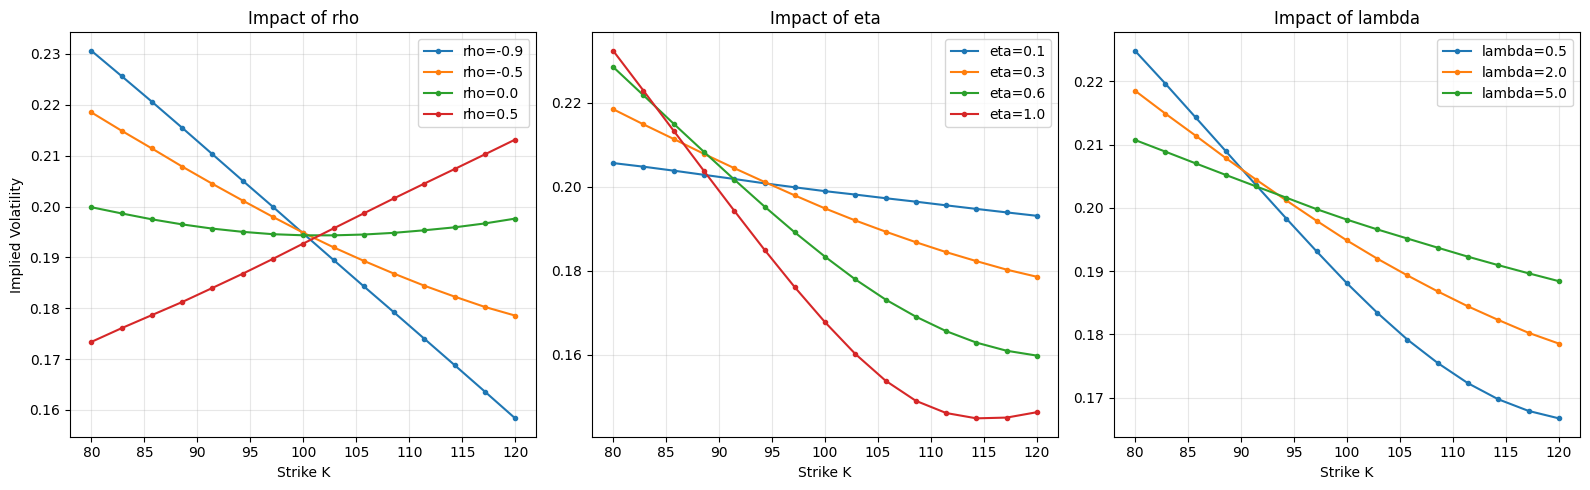

In [29]:
# Execution of 3 Plots
print("Calculating sensitivity curves...")
plt.figure(figsize=(16, 5))

# 1. Effect of Correlation (Rho) -> The Skew (Slope)
plot_sensitivity_with_existing_funcs('rho', [-0.9, -0.5, 0.0, 0.5], 1)

# 2. Effect of Vol-of-Vol (Eta) -> The Smile (Convexity)
plot_sensitivity_with_existing_funcs('eta', [0.1, 0.3, 0.6, 1.0], 2)

# 3. Effect of Mean-Reversion (Lambda) -> Global Shape
plot_sensitivity_with_existing_funcs('lambda', [0.5, 2.0, 5.0], 3)

plt.tight_layout()
plt.show()

**Graph  1 :**

 $\rho$ (Corrélation) influences the slope of the skew.

 - For $\rho < 0$ (standard case for stocks), the curve decreases.

 - For $\rho = 0$, it's a symmetric smile ("U").

 - For $\rho > 0$, the curve increases.

**Graph 2 :**

$\eta$ (Volatility of volatility) influences the intensity of the skew's convexity.

- The larger $\eta$ is, the higher the edges rise (OTM and ITM options are expensive).

- If $\eta$ is small, we approach a flat line (Black-Scholes).


**Graph 3 :**

$\lambda$ (Mean reversion speed) has a dampening effect.

- A large $\lambda$ "rigidifies" the variance near its mean, which tends to flatten the smile.